In [9]:
import numpy as np
import emcee
from matplotlib import pyplot as plt
import corner
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
mean = np.array([5, 8, 3, 2])
cov = np.diag(np.array([3, 2, 1, 0.5]))
ndim = len(mean)
nwalkers = ndim * 2
invcov = np.linalg.inv(cov)

def logpdf(x):
    return -((x - mean) @ invcov @ (x - mean))

p0 = np.random.randn(nwalkers, ndim)

def mh_proposal(coords, rng=np.random.default_rng):
    candidate = np.array([np.random.multivariate_normal(coord, cov) for coord in coords])
    diff_log_prob = list([
                       -((candidate[i] - mean) @ invcov @ (candidate[i] - mean)) + ((coords[i] - mean) @ invcov @ (coords[i] - mean))
                        for i in range(nwalkers)
    ])
    return candidate, diff_log_prob

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpdf, moves=[emcee.moves.MHMove(mh_proposal)])
_ = sampler.run_mcmc(p0, 1000, progress='notebook')

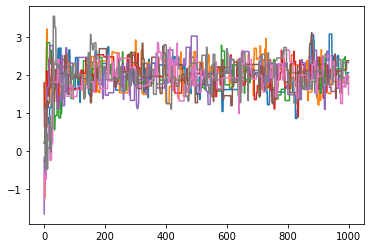

In [92]:
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,3])

In [93]:
sampler.chain.shape

(8, 1000, 4)

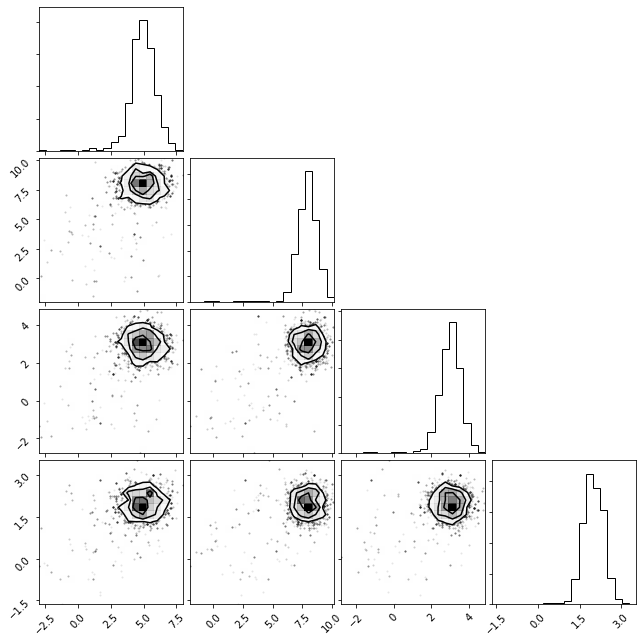

In [94]:
_ = corner.corner(sampler.flatchain)

In [142]:
mean = 3
sd = 2
data_size = 5
ndim = 2
nwalkers = 10
gaussian_data = np.random.normal(mean, sd, size=data_size)
pseudo_log_prob_per = lambda d, p: 0
bound_prob = lambda p: (np.mean(gaussian_data) - p[0]) ** 2 / (2 * p[1] ** 2)

def log_prob(param):
    # yay for exponential families
    if param[1] < 0:
        return -1e6
    return -(np.mean(gaussian_data) - param[0]) ** 2 / (2 * param[1] ** 2)

def proposal(params, rng=np.random.default_rng):
    candidate = np.array([np.random.multivariate_normal(param, np.diag([0.1, 0.1])) for param in params])
    diff_log_prob = np.array([
        log_prob(cand) - log_prob(param) for cand, param in zip(candidate, params)
    ])
    return candidate, diff_log_prob

p0 = np.random.randn(nwalkers, ndim)

mh_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=[emcee.moves.MHMove(proposal)])
for _ in range(10):
    _ = mh_sampler.run_mcmc(p0, 500, progress='notebook')
    p0 = np.median(mh_sampler.chain, axis=1)
    p0 += np.random.normal(0, 1e-3, p0.shape)

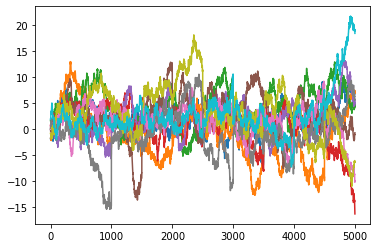

In [143]:
for i in range(nwalkers):
    plt.plot(mh_sampler.chain[i,:,0])

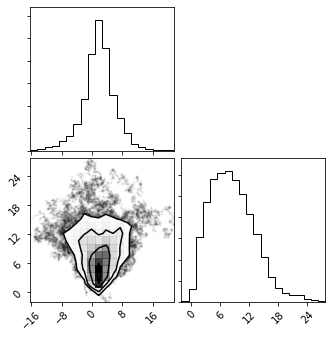

In [144]:
_ = corner.corner(mh_sampler.flatchain)

In [145]:
from IPython.display import display, Math
labels = ['mean', 'sd']
best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(mh_sampler.get_chain(thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [124]:
firefly_move = emcee.moves.FireflyMove(
    datapoints=gaussian_data,
    pseudo_log_prob_per=pseudo_log_prob_per,
    bound_prob=bound_prob,
    proposal_function=mh_proposal,
    nwalkers=nwalkers,
    ndim=ndim
)

firefly_sampler = emcee.EnsembleSampler(nwalkers, ndim, logpdf, moves=[firefly_move])
_ = firefly_sampler.run_mcmc(p0, 1000, progress='notebook')

emcee: Exception while calling your likelihood function:
  params: [-1.46305419 -0.70289368]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-91-b1bd1972e2bc>", line 8, in logpdf
    return -((x - mean) @ invcov @ (x - mean))
ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [27]:
firefly_move.fireflies

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])